<a href="https://colab.research.google.com/github/RMoulla/Machine-learning/blob/main/R%C3%A9gression_logistique_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP : Régression logistique sur les données du Titanic

Dans ce TP, nous allons implémenter une régression logisitique from scratch, sans avoior recours aux librairies de Scikit-learn. Le dataset considéré ici est un dataset très simple, celui du Titanic. L'objectif est de prédire les individus qui ont survécu au naufrage, à partir d'un certain nombre de variables comme l'âge, la classe, etc. Il s'agit donc d'une classification binaire (si un individu a survécu '1' ou non '0').

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math

In [ ]:
dataset = pd.read_csv('titanic.csv')
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Prétraitement des données

Nous allons effectuer ici un prétraitement assez sommaire des données en supprimant les variables qui, à première vue, n'apportent pas une information significative au modèle.
Nous allons également supprimer les lignes comportant des valeurs manquantes dans la mesure où le nombre de points de données est relativement suffisant pour un modèle linéaire comme la régression logistique.

In [ ]:
dataset = dataset.drop(['Name', 'Ticket', 'Cabin', 'PassengerId'], axis=1)

In [ ]:
dataset = dataset.dropna()
dataset.shape

(712, 8)

In [ ]:
dataset = pd.get_dummies(dataset, columns=['Sex', 'Embarked'], drop_first=True)
dataset.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


Ici, nous isolons la variable à prédire "Survived" des features (le reste des colonnes du dataframe).
Nous partionnons ensuite les données en jeu de données d'entrainement et jeu de données de test (70% pour l'entrainement et 30% pour le test).

In [ ]:
X = dataset.drop('Survived', axis=1)
y = dataset['Survived']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Modèle de régression logistique

Nous avons vu en cours que le modèle logistique permet de prédire la classe d'un individu, défini par son vecture de features $x$, à l'aide de la fonction sigmoïde :

$$\hat{y} = \frac{1}{1+e^{-\beta.x}}$$

où les $\beta$ sont les paramètres du modèle (les coefficients de la régression).

Entraîner un modèle de régression logisitique revient alors à calculer ces paramètres $\beta$ en minimisant le risque empirique. Autrement dit, on recherche les paramètres $\beta$ qui minimisent la moyenne des erreurs de prédiction sur l'ensemble du jeu de données d'entrainement, en considérant la fonction coût (loss) appelée entropie croisée :

$$J(\beta) = -\frac{1}{n} \sum_{1}^n y_i\ln(\hat{y_i}) +
(1-y_i)\ln(1-\hat{y_i})$$

Les coefficients $\beta$ peuvent alors être caclculés grâce à un algorithme de descente du gradient :

$$\beta_j ← \beta_j - \alpha\frac{∂J(\beta)}{\partial\beta_j}$$

où $\alpha$ est le pas de progression, appelé *learning rate*.

On peut montrer que les gradients, dans ce cas, se calculent de la manière suivante :

 $$\frac{∂J(\beta)}{\partial\beta_j} = -(y-\hat{y}).x_j$$

 $x_j$ étant la variable (feature) associée à $\beta_j$. On notera que pour $j = 0$ (autrement dit $\beta_0$ ou le biais), la variable correspondante, $x_0$, est tout simplement l'identité. Les gradients peuvent ainsi être calculés comme suit :

\begin{equation}
\left\{
     \begin{array}{ll}
       \frac{∂J(\beta)}{\partial\beta_j} = -(y-\hat{y}).x_j \ \ \ Si \ j = 1,...,p\\
       \frac{∂J(\beta)}{\partial\beta_0} = -(y-\hat{y})
     \end{array}
\right.
\end{equation}

 Nous avons tous les élements nécessaire pour calculer notre modèle de régression logisitique.

In [ ]:
def sigmoid(z):
    """
    Calcule la fonction sigmoïde d'une entrée z (un scalaire ou un tableau numpy).

   Entrées :
    z (np.array): La valeur d'entrée pour laquelle la fonction sigmoïde est calculée.

    Sorties :
    np.array: La valeur de la fonction sigmoïde appliquée à chaque élément de z.
    """
    z = np.clip(z, -100, 100) # Permet de limiter les valeurs prises par z pour éviter les valeurs infinies
    return 1 / (1 + np.exp(-z))

def logistic_loss(y, y_predicted):
    """
    Calcule la fonction de coût entropie croisée pour les prédictions.

    Entrées :
    y (np.array) : Les valeurs réelles (vraies étiquettes).
    y_predicted (np.array) : Les valeurs prédites par le modèle.

    Sorties :
    float : La valeur moyenne de la fonction de coût sur les prédictions.
    """
    epsilon = 1e-15
    y_predicted = np.clip(y_predicted, epsilon, 1 - epsilon)
    return -np.mean(y * np.log(y_predicted) + (1 - y) * np.log(1 - y_predicted))

In [ ]:
def train_logistic_regression(X_train, y_train, X_test, y_test, learning_rate, n_iter):
    """
    Entraîne un modèle de régression logistique en utilisant un algorithme de descente de gradient.

    Entrées :
    X_train (np.array) : Les caractéristiques de l'ensemble d'entraînement.
    y_train (np.array) : Les étiquettes de l'ensemble d'entraînement.
    learning_rate (float) : Le pas d'apprentissage pour la mise à jour des poids.
    n_iter (int) : Le nombre d'itérations pour l'entraînement.

    Sorties :
    np.array : Le vecteur des poids (weights) après l'entraînement (beta_j pour tous les j différents de 0).
    float : La valeur du biais (bias) après l'entraînement (beta_0).
    """
    n_samples, n_features = X_train.shape

    ####### Initialisation des coefficients de la régression ########
    weights = np.zeros(n_features)
    bias = 0
    #################################################################


    losses_train = [] # Liste pour sauvegarder toutes les loss d'entrainement afin de les tracer ensuite
    losses_test = []  # Liste pour sauvegarder toutes les loss de test afin de les tracer ensuite

    ######## Début de la descente du gradient #########
    for i in range(n_iter):
        # On calcule les prédictions et la loss sur le train avec les coefficients calculés à cette itération
        predictions_train = predict_logistic_regression(X_train, weights, bias)
        y_train = np.array(y_train) # Transformer la liste en vecteur (objet np.array)
        loss_train = logistic_loss(y_train, predictions_train)
        losses_train.append(loss_train)

        # On fait la même chose pour le test
        predictions_test = predict_logistic_regression(X_test, weights, bias)
        y_test = np.array(y_test)
        loss_test = logistic_loss(y_test, predictions_test)
        losses_test.append(loss_test)

        ########### Compléter le code ################
        # Il faut calculer les gradients dw et db correspondant respectivement aux coefficients beta et beta_0
        # Il suffit de se référer aux équations du gradient et de noter dw peut être calculé d'une manière matricielle


        db_ = (predictions_train - y_train )
        dw =  (1/n_samples) * np.dot(X_train.T ,db_ )
        db = np.mean(db_)

        ##############################################

        weights -= learning_rate * dw
        bias -= learning_rate * db


        # Cette boucle sert simplement à afficher quelques résultats chaque 1000 itérations
        if i % 1000 == 0 or i == n_iter - 1:
            train_accuracy = accuracy_score(X_train, y_train, weights, bias)
            test_accuracy = accuracy_score(X_test, y_test, weights, bias)
            print(f'Iter {i}, Train loss: {loss_train:.4f}, Test loss: {loss_test:.4f}, Train accuracy: {train_accuracy:.2f}, Test accuracy: {test_accuracy:.2f}')


    # Ici on trace les loss sur le train et le test pour vérifier qu'elles diminuent bien
    plt.plot(losses_train, label='Train Loss')
    plt.plot(losses_test, label='Test Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return weights, bias

In [ ]:
def predict_logistic_regression(X, weights, bias):
    """
    Prédit les étiquettes d'un ensemble de données en utilisant les poids et le biais d'un modèle.

    Entrées :
    X (np.array) : Les features nécessaires pour prédire.
    weights (np.array): Le vecteur des poids utilisé pour les prédictions.
    bias (float): Le biais (\beta_0) utilisé pour les prédictions.

    Sorties :
    np.array: Les étiquettes prédites pour chaque exemple dans X.
    """

    ########## Compléter le code ##########
    # Il faut calculer ici les prédictions, à partir des features X et des coefficients weights et bias, à
    # l'aide de la fonction sigmoïde

    predictions = sigmoid(np.dot(X,  weights)+bias)

    ######################################
    return predictions

def accuracy_score(X, y, weights, bias):
    """ Cette fonction calcule l'accuracy du modèle.

    Entrées :
    X_train (np.array) : Les caractéristiques de l'ensemble d'entraînement.
    y_train (np.array) : Les étiquettes de l'ensemble d'entraînement.
    weights (np.array) : Le vecteur des poids (coefficients de la régression).
    bias (float) : La valeur du biais (bias).

    Sorties :
    float : l'accuracy du modèle (nombre de bonnes prédictions divisé par le nombre total de prédictions).
    """

    predictions = predict_logistic_regression(X, weights, bias)
    prediction_class = [1 if i > 0.5 else 0 for i in predictions]
    nb_right_predictions = np.sum(prediction_class == y)
    return nb_right_predictions/len(y)

Iter 0, Train loss: 0.6931, Test loss: 0.6931, Train accuracy: 0.70, Test accuracy: 0.66
Iter 1000, Train loss: 0.5709, Test loss: 0.6271, Train accuracy: 0.73, Test accuracy: 0.68
Iter 2000, Train loss: 0.5398, Test loss: 0.6000, Train accuracy: 0.76, Test accuracy: 0.70
Iter 3000, Train loss: 0.5170, Test loss: 0.5809, Train accuracy: 0.78, Test accuracy: 0.71
Iter 4000, Train loss: 0.4995, Test loss: 0.5682, Train accuracy: 0.78, Test accuracy: 0.74
Iter 5000, Train loss: 0.4873, Test loss: 0.5644, Train accuracy: 0.79, Test accuracy: 0.76
Iter 6000, Train loss: 0.4810, Test loss: 0.5604, Train accuracy: 0.80, Test accuracy: 0.75
Iter 7000, Train loss: 0.4761, Test loss: 0.5571, Train accuracy: 0.80, Test accuracy: 0.78
Iter 8000, Train loss: 0.4720, Test loss: 0.5547, Train accuracy: 0.79, Test accuracy: 0.77
Iter 9000, Train loss: 0.4687, Test loss: 0.5527, Train accuracy: 0.80, Test accuracy: 0.78
Iter 9999, Train loss: 0.4658, Test loss: 0.5510, Train accuracy: 0.79, Test accura

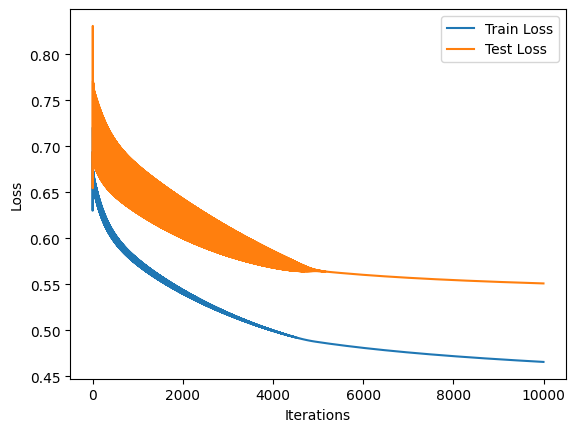

In [ ]:
# Exécution du modèle
weights, bias = train_logistic_regression(X_train, y_train, X_test, y_test, learning_rate=0.005, n_iter=10000)

#Modèle de régression logistique avec un paramètre de régulation

Ici, les différences concernent essentiellement le calcul de la fonction de perte logistique où on ajoute un terme de régulation. On note aussi l'ajout d'un terme de régulation dans le gradient relatif au coefficient beta au niveau de la fonction d'entrainement de la regression logistique. Il s'agit ici de la **régularisation L2** (régularisation Ridge)

In [ ]:
def sigmoid(z):
    """
    Calcule la fonction sigmoïde d'une entrée z (un scalaire ou un tableau numpy).

   Entrées :
    z (np.array): La valeur d'entrée pour laquelle la fonction sigmoïde est calculée.

    Sorties :
    np.array: La valeur de la fonction sigmoïde appliquée à chaque élément de z.
    """
    z = np.clip(z, -100, 100) # Permet de limiter les valeurs prises par z pour éviter les valeurs infinies
    return 1 / (1 + np.exp(-z))



def logistic_loss(y, y_predicted, weights, regularization_strength):

  """
  Calcule la fonction de coût entropie croisée pour les prédictions.

  Entrées :
  y (np.array) : Les valeurs réelles (vraies étiquettes).
  y_predicted (np.array) : Les valeurs prédites par le modèle.
  weights (np.array): Le vecteur des poids utilisé pour les prédictions.
  regularization_strength : paramètre de régulation


  Sorties :
  float : La valeur moyenne de la fonction de coût sur les prédictions.
  """

  epsilon = 1e-15
  y_predicted = np.clip(y_predicted, epsilon, 1 - epsilon)
  # Termes de perte sans régularisation
  loss_terms = -y * np.log(y_predicted) - (1 - y) * np.log(1 - y_predicted)
  # Terme de régularisation L2
  regularization_term = (regularization_strength / (2 * len(y))) * np.sum(weights**2)
  return np.mean(loss_terms) + regularization_term

In [ ]:
def train_logistic_regression(X_train, y_train, X_test, y_test, learning_rate, n_iter, regularization_strength):
    """
    Entraîne un modèle de régression logistique en utilisant un algorithme de descente de gradient.

    Entrées :
    X_train (np.array) : Les caractéristiques de l'ensemble d'entraînement.
    y_train (np.array) : Les étiquettes de l'ensemble d'entraînement.
    learning_rate (float) : Le pas d'apprentissage pour la mise à jour des poids.
    n_iter (int) : Le nombre d'itérations pour l'entraînement.
    regularization_strength : paramètre de régulation

    Sorties :
    np.array : Le vecteur des poids (weights) après l'entraînement (beta_j pour tous les j différents de 0).
    float : La valeur du biais (bias) après l'entraînement (beta_0).
    """
    n_samples, n_features = X_train.shape

    ####### Initialisation des coefficients de la régression ########
    weights = np.zeros(n_features)
    bias = 0
    #################################################################


    losses_train = [] # Liste pour sauvegarder toutes les loss d'entrainement afin de les tracer ensuite
    losses_test = []  # Liste pour sauvegarder toutes les loss de test afin de les tracer ensuite

    ######## Début de la descente du gradient #########
    for i in range(n_iter):
        # On calcule les prédictions et la loss sur le train avec les coefficients calculés à cette itération
        predictions_train = predict_logistic_regression(X_train, weights, bias)
        y_train = np.array(y_train) # Transformer la liste en vecteur (objet np.array)
        loss_train = logistic_loss(y_train, predictions_train, weights, regularization_strength)
        losses_train.append(loss_train)

        # On fait la même chose pour le test
        predictions_test = predict_logistic_regression(X_test, weights, bias)
        y_test = np.array(y_test)
        loss_test = logistic_loss(y_test, predictions_test, weights, regularization_strength)
        losses_test.append(loss_test)

        ########### Compléter le code ################
        # Il faut calculer les gradients dw et db correspondant respectivement aux coefficients beta et beta_0
        # Il suffit de se référer aux équations du gradient et de noter dw peut être calculé d'une manière matricielle


        db_ = (predictions_train - y_train )
        dw =  (1/n_samples) * (np.dot(X_train.T ,db_ ) + regularization_strength * weights)
        db = np.mean(db_)

        ##############################################

        weights -= learning_rate * dw
        bias -= learning_rate * db


        # Cette boucle sert simplement à afficher quelques résultats chaque 1000 itérations
        if i % 1000 == 0 or i == n_iter - 1:
            train_accuracy = accuracy_score(X_train, y_train, weights, bias)
            test_accuracy = accuracy_score(X_test, y_test, weights, bias)
            print(f'Iter {i}, Train loss: {loss_train:.4f}, Test loss: {loss_test:.4f}, Train accuracy: {train_accuracy:.2f}, Test accuracy: {test_accuracy:.2f}')


    # Ici on trace les loss sur le train et le test pour vérifier qu'elles diminuent bien
    plt.plot(losses_train, label='Train Loss')
    plt.plot(losses_test, label='Test Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return weights, bias

In [ ]:
def predict_logistic_regression(X, weights, bias):
    """
    Prédit les étiquettes d'un ensemble de données en utilisant les poids et le biais d'un modèle.

    Entrées :
    X (np.array) : Les features nécessaires pour prédire.
    weights (np.array): Le vecteur des poids utilisé pour les prédictions.
    bias (float): Le biais (\beta_0) utilisé pour les prédictions.

    Sorties :
    np.array: Les étiquettes prédites pour chaque exemple dans X.
    """

    ########## Compléter le code ##########
    # Il faut calculer ici les prédictions, à partir des features X et des coefficients weights et bias, à
    # l'aide de la fonction sigmoïde

    predictions = sigmoid(np.dot(X,  weights)+bias)

    ######################################
    return predictions

def accuracy_score(X, y, weights, bias):
    """ Cette fonction calcule l'accuracy du modèle.

    Entrées :
    X_train (np.array) : Les caractéristiques de l'ensemble d'entraînement.
    y_train (np.array) : Les étiquettes de l'ensemble d'entraînement.
    weights (np.array) : Le vecteur des poids (coefficients de la régression).
    bias (float) : La valeur du biais (bias).

    Sorties :
    float : l'accuracy du modèle (nombre de bonnes prédictions divisé par le nombre total de prédictions).
    """

    predictions = predict_logistic_regression(X, weights, bias)
    prediction_class = [1 if i > 0.5 else 0 for i in predictions]
    nb_right_predictions = np.sum(prediction_class == y)
    return nb_right_predictions/len(y)

Valaur du paramètre de régulation : 0.1
Iter 0, Train loss: 0.6931, Test loss: 0.6931, Train accuracy: 0.70, Test accuracy: 0.66
Iter 1000, Train loss: 0.5710, Test loss: 0.6272, Train accuracy: 0.73, Test accuracy: 0.68
Iter 2000, Train loss: 0.5399, Test loss: 0.6002, Train accuracy: 0.76, Test accuracy: 0.70
Iter 3000, Train loss: 0.5172, Test loss: 0.5812, Train accuracy: 0.78, Test accuracy: 0.71
Iter 4000, Train loss: 0.4998, Test loss: 0.5687, Train accuracy: 0.78, Test accuracy: 0.74
Iter 5000, Train loss: 0.4877, Test loss: 0.5648, Train accuracy: 0.79, Test accuracy: 0.76
Iter 6000, Train loss: 0.4814, Test loss: 0.5610, Train accuracy: 0.80, Test accuracy: 0.75
Iter 7000, Train loss: 0.4765, Test loss: 0.5579, Train accuracy: 0.80, Test accuracy: 0.78
Iter 8000, Train loss: 0.4725, Test loss: 0.5554, Train accuracy: 0.79, Test accuracy: 0.77
Iter 9000, Train loss: 0.4691, Test loss: 0.5535, Train accuracy: 0.80, Test accuracy: 0.78
Iter 9999, Train loss: 0.4663, Test loss: 0

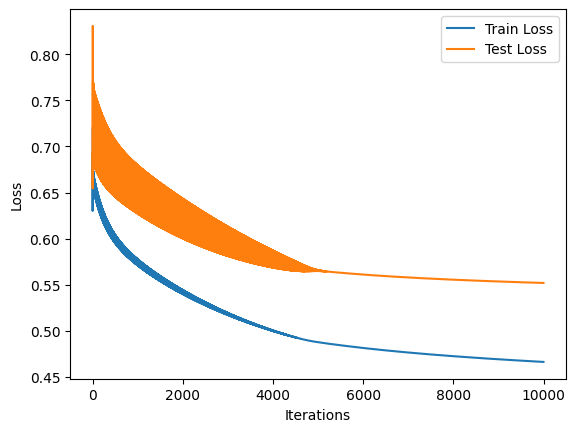

---------------------------------------------------------------------------------------
Valaur du paramètre de régulation : 1
Iter 0, Train loss: 0.6931, Test loss: 0.6931, Train accuracy: 0.70, Test accuracy: 0.66
Iter 1000, Train loss: 0.5715, Test loss: 0.6279, Train accuracy: 0.73, Test accuracy: 0.68
Iter 2000, Train loss: 0.5412, Test loss: 0.6022, Train accuracy: 0.75, Test accuracy: 0.70
Iter 3000, Train loss: 0.5194, Test loss: 0.5844, Train accuracy: 0.78, Test accuracy: 0.71
Iter 4000, Train loss: 0.5029, Test loss: 0.5729, Train accuracy: 0.78, Test accuracy: 0.73
Iter 5000, Train loss: 0.4907, Test loss: 0.5684, Train accuracy: 0.79, Test accuracy: 0.75
Iter 6000, Train loss: 0.4846, Test loss: 0.5666, Train accuracy: 0.80, Test accuracy: 0.75
Iter 7000, Train loss: 0.4801, Test loss: 0.5641, Train accuracy: 0.79, Test accuracy: 0.77
Iter 8000, Train loss: 0.4764, Test loss: 0.5623, Train accuracy: 0.79, Test accuracy: 0.77
Iter 9000, Train loss: 0.4733, Test loss: 0.5608,

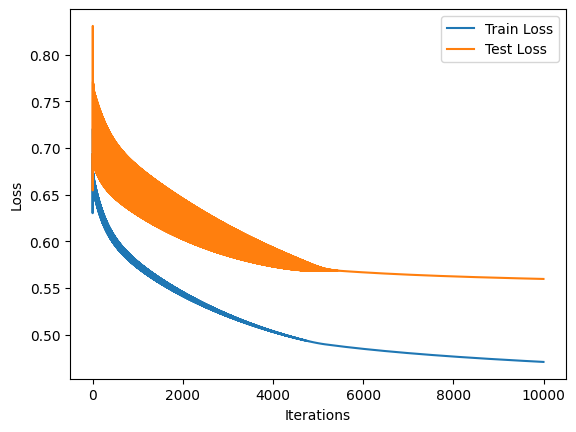

---------------------------------------------------------------------------------------
Valaur du paramètre de régulation : 2
Iter 0, Train loss: 0.6931, Test loss: 0.6931, Train accuracy: 0.70, Test accuracy: 0.66
Iter 1000, Train loss: 0.5720, Test loss: 0.6288, Train accuracy: 0.73, Test accuracy: 0.68
Iter 2000, Train loss: 0.5426, Test loss: 0.6042, Train accuracy: 0.74, Test accuracy: 0.70
Iter 3000, Train loss: 0.5217, Test loss: 0.5879, Train accuracy: 0.77, Test accuracy: 0.71
Iter 4000, Train loss: 0.5061, Test loss: 0.5775, Train accuracy: 0.78, Test accuracy: 0.73
Iter 5000, Train loss: 0.4945, Test loss: 0.5724, Train accuracy: 0.79, Test accuracy: 0.74
Iter 6000, Train loss: 0.4880, Test loss: 0.5724, Train accuracy: 0.80, Test accuracy: 0.75
Iter 7000, Train loss: 0.4839, Test loss: 0.5706, Train accuracy: 0.79, Test accuracy: 0.76
Iter 8000, Train loss: 0.4805, Test loss: 0.5692, Train accuracy: 0.80, Test accuracy: 0.77
Iter 9000, Train loss: 0.4776, Test loss: 0.5681,

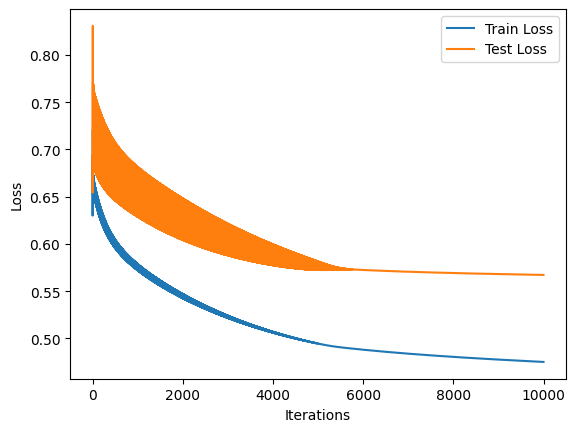

---------------------------------------------------------------------------------------
Valaur du paramètre de régulation : 10
Iter 0, Train loss: 0.6931, Test loss: 0.6931, Train accuracy: 0.70, Test accuracy: 0.66
Iter 1000, Train loss: 0.5763, Test loss: 0.6350, Train accuracy: 0.73, Test accuracy: 0.68
Iter 2000, Train loss: 0.5525, Test loss: 0.6190, Train accuracy: 0.73, Test accuracy: 0.69
Iter 3000, Train loss: 0.5377, Test loss: 0.6111, Train accuracy: 0.77, Test accuracy: 0.72
Iter 4000, Train loss: 0.5278, Test loss: 0.6075, Train accuracy: 0.77, Test accuracy: 0.73
Iter 5000, Train loss: 0.5211, Test loss: 0.6061, Train accuracy: 0.78, Test accuracy: 0.73
Iter 6000, Train loss: 0.5164, Test loss: 0.6057, Train accuracy: 0.78, Test accuracy: 0.73
Iter 7000, Train loss: 0.5130, Test loss: 0.6058, Train accuracy: 0.79, Test accuracy: 0.73
Iter 8000, Train loss: 0.5105, Test loss: 0.6060, Train accuracy: 0.78, Test accuracy: 0.73
Iter 9000, Train loss: 0.5087, Test loss: 0.6062

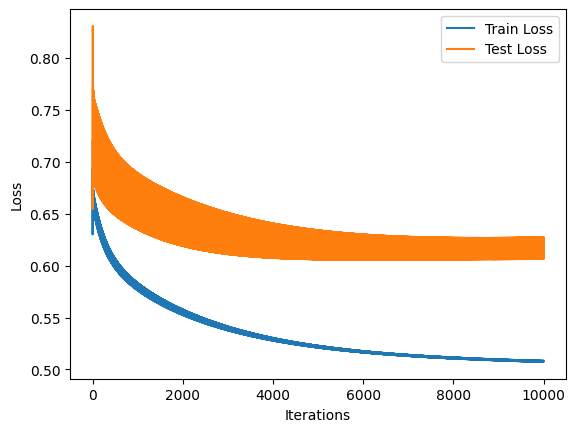

---------------------------------------------------------------------------------------
Valaur du paramètre de régulation : 100
Iter 0, Train loss: 0.6931, Test loss: 0.6931, Train accuracy: 0.70, Test accuracy: 0.66
Iter 1000, Train loss: 0.6068, Test loss: 0.6738, Train accuracy: 0.73, Test accuracy: 0.66
Iter 2000, Train loss: 0.6044, Test loss: 0.6794, Train accuracy: 0.72, Test accuracy: 0.66
Iter 3000, Train loss: 0.6040, Test loss: 0.6818, Train accuracy: 0.73, Test accuracy: 0.67
Iter 4000, Train loss: 0.6039, Test loss: 0.6829, Train accuracy: 0.73, Test accuracy: 0.67
Iter 5000, Train loss: 0.6038, Test loss: 0.6836, Train accuracy: 0.73, Test accuracy: 0.68
Iter 6000, Train loss: 0.6038, Test loss: 0.6842, Train accuracy: 0.74, Test accuracy: 0.68
Iter 7000, Train loss: 0.6038, Test loss: 0.6847, Train accuracy: 0.74, Test accuracy: 0.68
Iter 8000, Train loss: 0.6038, Test loss: 0.6852, Train accuracy: 0.74, Test accuracy: 0.68
Iter 9000, Train loss: 0.6038, Test loss: 0.685

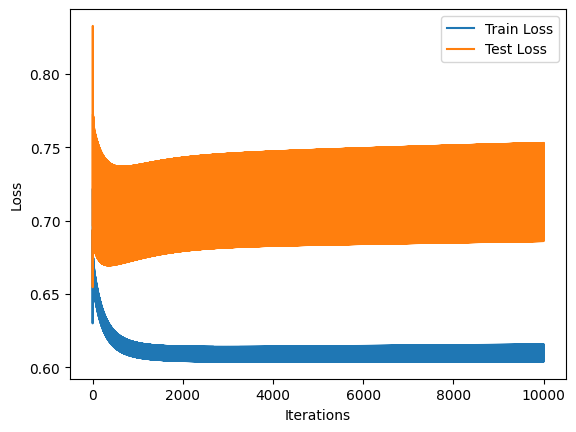

---------------------------------------------------------------------------------------


In [ ]:
regularization_values = [0.1, 1, 2, 10, 100]

for x in regularization_values:
    print(f"Valaur du paramètre de régulation : {x}")
    # Exécution du modèle
    weights, bias = train_logistic_regression(X_train, y_train, X_test, y_test, learning_rate=0.005, n_iter=10000, regularization_strength=x)
    print("---------------------------------------------------------------------------------------")